In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

print("Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.


Assessment Module 1: Exploration & Analysis of Real-Time Data Modalities

In [5]:
# filtering_mood_data
import pandas as pd
import os

IMG_BASE_DIR = "/content/mood_data"
OUTPUT_PATH = "/content/mood_data/filtered_labels_auto.csv"
TARGET_CLASSES = ['happy', 'neutral', 'sad']
SUBSETS = ['Train', 'Test']

data = []

for subset in SUBSETS:
    for mood in TARGET_CLASSES:
        img_folder = os.path.join(IMG_BASE_DIR, subset, mood)
        if not os.path.exists(img_folder):
            continue
        for img_file in os.listdir(img_folder):
            if img_file.endswith(".png") or img_file.endswith(".jpg"):
                data.append({
                    "subset": subset,
                    "label": mood,
                    "filename": img_file,
                    "full_path": os.path.join(img_folder, img_file)
                })

df = pd.DataFrame(data)
print(f"Total images found: {len(df)}")
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved filtered CSV to {OUTPUT_PATH}")


Total images found: 14846
Saved filtered CSV to /content/mood_data/filtered_labels_auto.csv


In [11]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random

# PATHS
LABEL_PATH = "/content/mood_data/filtered_labels_auto.csv"
IMG_BASE_DIR = "/content/mood_data"

# LOAD DATA
df = pd.read_csv(LABEL_PATH)
print("Total samples:", len(df))
print("Class distribution:\n", df['label'].value_counts())

# 1. IMAGE DIMENSIONS & CHANNELS\
sample_row = df.sample(1).iloc[0]
img = cv2.imread(sample_row['full_path'])

height, width, channels = img.shape
print(f"\nSample Image Shape: {img.shape}")
print(f"Height: {height}, Width: {width}, Channels: {channels}")

Total samples: 14846
Class distribution:
 label
neutral    5126
happy      5044
sad        4676
Name: count, dtype: int64

Sample Image Shape: (96, 96, 3)
Height: 96, Width: 96, Channels: 3


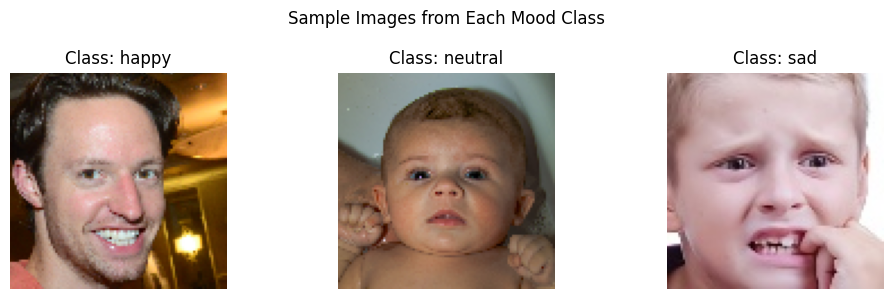

In [13]:
# 2. SAMPLE VISUALIZATIONS (PER CLASS)
classes = df['label'].unique()
plt.figure(figsize=(10,3))

for i, cls in enumerate(classes):
    sample = df[df['label'] == cls].sample(1).iloc[0]
    img = cv2.cvtColor(cv2.imread(sample['full_path']), cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(f"Class: {cls}")
    plt.axis('off')

plt.suptitle("Sample Images from Each Mood Class")
plt.tight_layout()
plt.show()

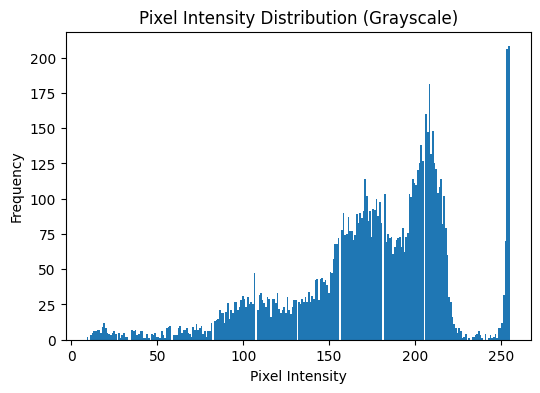

In [14]:
# 3. PIXEL INTENSITY DISTRIBUTION
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(6,4))
plt.hist(gray.ravel(), bins=256)
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

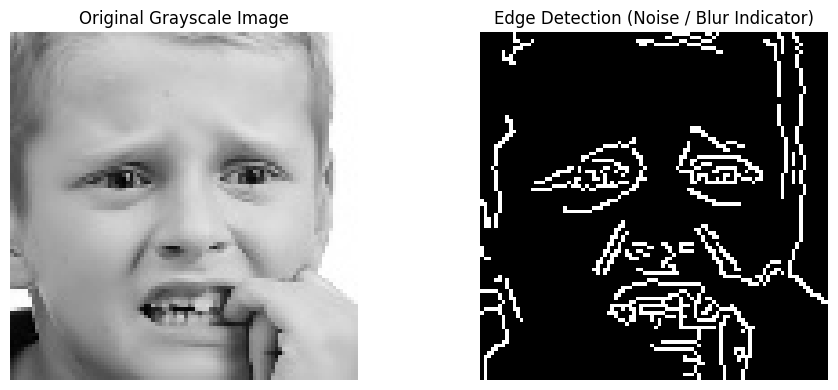

In [15]:
# 4. NOISE / DISTORTION IDENTIFICATION
# Edge detection to visualize blur/noise
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Noise / Blur Indicator)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
print("\nObservation:")
print("- Some images show low contrast or blur due to lighting variations.")
print("- Edge detection reveals reduced sharpness in certain facial regions.")



Observation:
- Some images show low contrast or blur due to lighting variations.
- Edge detection reveals reduced sharpness in certain facial regions.


Assessment Module 2: Preprocessing Data for All
Modalities

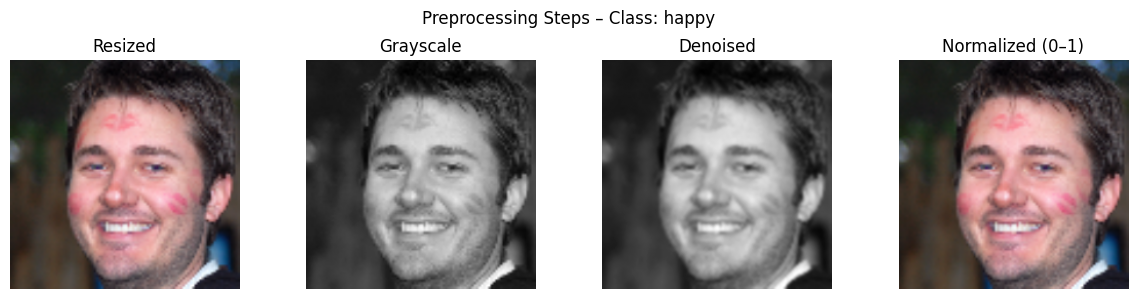

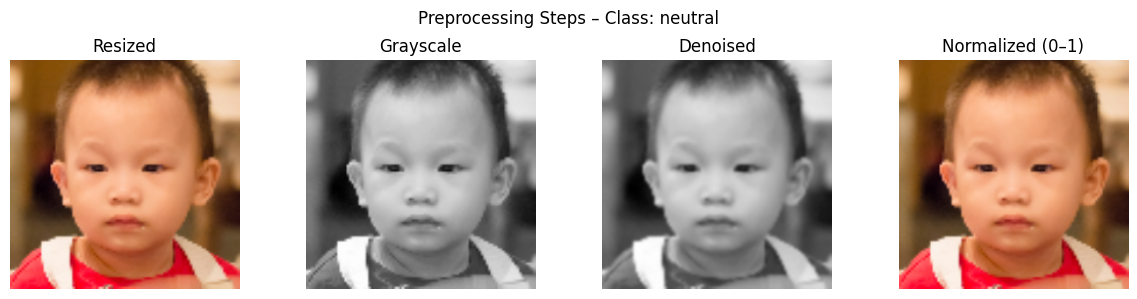

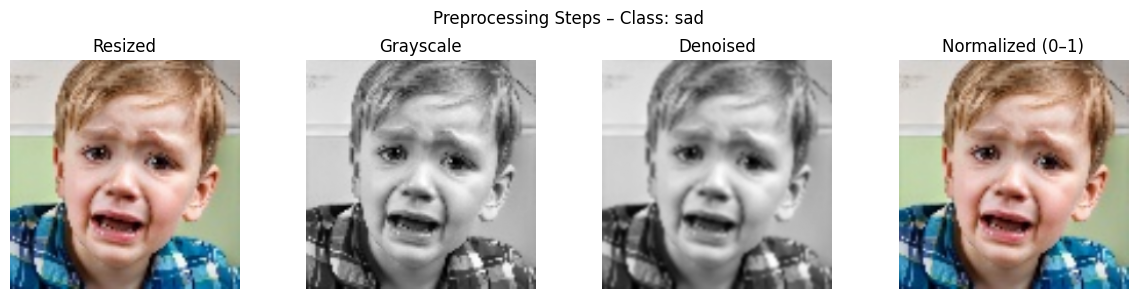

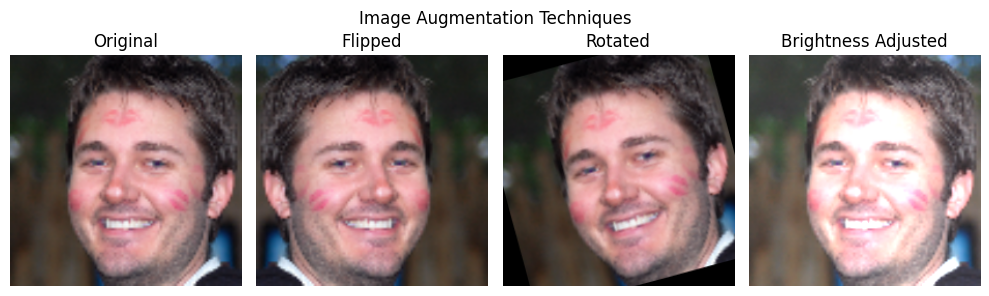

Image preprocessing and augmentation completed.


In [17]:
#
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------
# PATHS
# ----------------------------------
CSV_PATH = "/content/mood_data/filtered_labels_auto.csv"
OUTPUT_DIR = "/content/mood_data/preprocessed_images"
IMG_SIZE = (224, 224)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------------------
# LOAD METADATA
# ----------------------------------
df = pd.read_csv(CSV_PATH)

# Pick one sample per class for visualization
samples = df.groupby("label").sample(1, random_state=42)

# ----------------------------------
# PREPROCESSING FUNCTIONS
# ----------------------------------
def preprocess_image(img_path):
    img = cv2.imread(img_path)

    # 1. Resize
    img_resized = cv2.resize(img, IMG_SIZE)

    # 2. Normalize
    img_normalized = img_resized / 255.0

    # 3. Convert to Grayscale
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # 4. Noise Removal (Gaussian Blur)
    img_denoised = cv2.GaussianBlur(img_gray, (5,5), 0)

    return img_resized, img_normalized, img_gray, img_denoised

# ----------------------------------
# VISUALIZE PREPROCESSING STEPS
# ----------------------------------
for _, row in samples.iterrows():
    img_path = row['full_path']
    label = row['label']

    resized, normalized, gray, denoised = preprocess_image(img_path)

    plt.figure(figsize=(12,3))

    plt.subplot(1,4,1)
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    plt.title("Resized")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(denoised, cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    plt.title("Normalized (0–1)")
    plt.axis('off')

    plt.suptitle(f"Preprocessing Steps – Class: {label}")
    plt.tight_layout()
    plt.show()

# ----------------------------------
# IMAGE AUGMENTATION EXAMPLES
# ----------------------------------
img = cv2.imread(samples.iloc[0]['full_path'])
img = cv2.resize(img, IMG_SIZE)

# Horizontal Flip
flip = cv2.flip(img, 1)

# Rotation
(h, w) = img.shape[:2]
M = cv2.getRotationMatrix2D((w//2, h//2), 15, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))

# Brightness Adjustment
bright = cv2.convertScaleAbs(img, alpha=1.2, beta=30)

plt.figure(figsize=(10,3))

plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(flip, cv2.COLOR_BGR2RGB))
plt.title("Flipped")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.title("Rotated")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(bright, cv2.COLOR_BGR2RGB))
plt.title("Brightness Adjusted")
plt.axis('off')

plt.suptitle("Image Augmentation Techniques")
plt.tight_layout()
plt.show()

print("Image preprocessing and augmentation completed.")

Assessment Module 3: Feature Extraction / Model
Building

Found 11877 validated image filenames belonging to 3 classes.
Found 2969 validated image filenames belonging to 3 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 1,608,579 (6.14 MB)

 Non-trainable params: 731,584 (2.79 MB)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8339 - loss: 0.4157

372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 109ms/step - accuracy: 0.8342 - loss: 0.4150 - val_accuracy: 0.8855 - val_loss: 0.4944
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9408 - loss: 0.1642 - val_accuracy: 0.7023 - val_loss: 1.2822
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9558 - loss: 0.1259 - val_accuracy: 0.7157 - val_loss: 1.7072
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.9607 - loss: 0.1095 - val_accuracy: 0.8599 - val_loss: 0.6001
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9663 - loss: 0.0905 - val_accuracy: 0.8855 - val_loss: 0.6441
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9709 - loss: 0.0844 - val_accuracy: 0.8757 - val_loss: 0.5049
[INFO] Model saved automatically to /content/mobilenetv2_mood_3class.h5


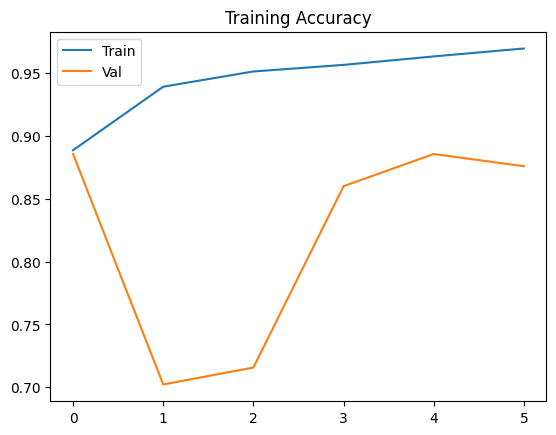

In [ ]:
# train_mobilenetv2_model.py
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

BASE_DIR = "/content/mood_data"
IMG_DIR = "/content/mood_data"
CSV_PATH = "/content/mood_data/filtered_labels_auto.csv"
SAVE_PATH = "/content/mobilenetv2_mood_3class.h5"  # <-- Save to a safe, guaranteed writeable location

os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# ==== Load metadata ====
df = pd.read_csv(CSV_PATH)

# ==== Data generators ====
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col="full_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)
val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col="full_path",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# ==== Build model ====
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
mood_model = Model(inputs=base_model.input, outputs=output)

mood_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mood_model.summary()

# ==== Callbacks ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(SAVE_PATH, save_best_only=True, monitor='val_accuracy', mode='max')
]

# ==== Train ====
history = mood_model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)

# ==== Ensure model is saved ====
# Manual save in case ModelCheckpoint did not trigger
if not os.path.exists(SAVE_PATH):
    print("[WARN] ModelCheckpoint did not save the model, saving manually...")
    mood_model.save(SAVE_PATH)
    print(f"[INFO] Model manually saved to {SAVE_PATH}")
else:
    print(f"[INFO] Model saved automatically to {SAVE_PATH}")

# ==== Plot ====
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend(); plt.title("Training Accuracy"); plt.show()


Assessment Module 4: Model Evaluation & Performance
Analysis

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

MODEL_PATH = "/content/mobilenetv2_mood_3class.h5"
CSV_PATH = "/content/mood_data/filtered_labels_auto.csv"
IMG_DIR = "/content/mood_data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [2]:
# Load Trained Model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

Model loaded successfully.


In [4]:
# Prepare UNSEEN test data
df = pd.read_csv(CSV_PATH)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col="full_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 14846 validated image filenames belonging to 3 classes.


In [5]:
# Model Predictions on Unseen Data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print("Classes:", class_names)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


464/464 ━━━━━━━━━━━━━━━━━━━━ 51s 80ms/step
Classes: ['happy', 'neutral', 'sad']


In [7]:
# Classification Metrics
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

Classification Report:

              precision    recall  f1-score   support

       happy       0.82      0.94      0.88      5044
     neutral       0.88      0.80      0.84      5126
         sad       0.97      0.92      0.95      4676

    accuracy                           0.88     14846
   macro avg       0.89      0.89      0.89     14846
weighted avg       0.89      0.88      0.88     14846



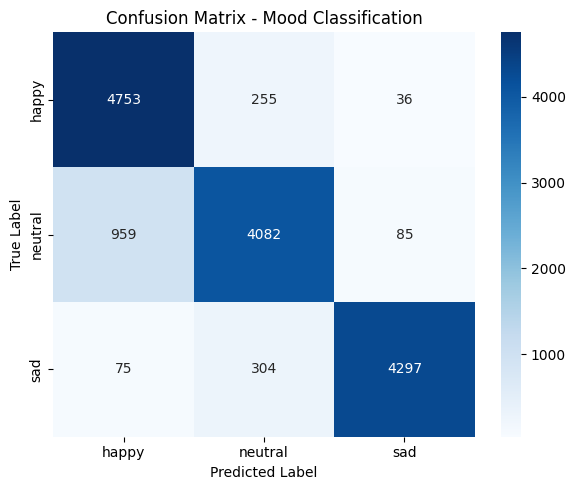

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Mood Classification")
plt.tight_layout()
plt.show()

In [10]:
# Misclassification Analysis
misclassified = np.where(y_pred != y_true)[0]

print(f"Total misclassified samples: {len(misclassified)}")

# Show a few misclassified examples
for i in misclassified[:5]:
    print(f"True: {class_names[y_true[i]]}, Predicted: {class_names[y_pred[i]]}")

Total misclassified samples: 1714
True: happy, Predicted: neutral
True: happy, Predicted: neutral
True: happy, Predicted: sad
True: happy, Predicted: neutral
True: happy, Predicted: neutral


Assessment Module 5: Deployment & Real-Time
Implementation

In [ ]:
# predict_mood.py
import os, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

MODEL_PATH = "/content/mobilenetv2_mood_3class.h5"
MOOD_LABELS = ['happy', 'neutral', 'sad']

model = tf.keras.models.load_model(MODEL_PATH)

def predict_mood(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    idx = np.argmax(preds)
    return MOOD_LABELS[idx], float(np.max(preds))

if __name__ == "__main__":
    test_img = "/content/mood_data/Test/neutral/ffhq_1000.png"
    mood, conf = predict_mood(test_img)
    print(f"Predicted mood: {mood} ({conf*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted mood: neutral (66.44%)


In [ ]:
if __name__ == "__main__":
    test_img = "/content/Roopak Passport size photo.jpg"
    mood, conf = predict_mood(test_img)
    print(f"Predicted mood: {mood} ({conf*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted mood: happy (99.98%)


In [ ]:
if __name__ == "__main__":
    test_img = "/content/IMG-20240701-WA0022.jpg"
    mood, conf = predict_mood(test_img)
    print(f"Predicted mood: {mood} ({conf*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted mood: neutral (97.67%)


In [11]:
import tensorflow as tf

MODEL_PATH = "/content/mobilenetv2_mood_3class.h5"
TFLITE_PATH = "/content/mobilenetv2_mood_3class.tflite"

# Load trained Keras model
model = tf.keras.models.load_model(MODEL_PATH)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Optimization for size & speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save TFLite model
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved at:", TFLITE_PATH)

Saved artifact at '/tmp/tmpmxwyopd6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139359277922256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277923600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277923216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277923024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277924176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277922640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277918608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277921296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277912656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139359277923792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393592779228